# Preparation

In [1]:
import pandas as pd
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
rel = pd.read_csv("data/NYCTAXI202401-202403.rel")
rel.head()

,rel_id,type,origin_id,destination_id,cost
0,0,geo,0,0,0.0
1,1,geo,0,1,31349.0
2,2,geo,0,2,33747.0
3,3,geo,0,3,17205.0
4,4,geo,0,4,14927.0


In [3]:
df_total = pd.read_csv("data/total/NYCTAXI_OD_Total.csv")

df_earlymorning = pd.read_csv("data/timeperiod/NYCTAXI_OD_Early Morning.csv")
df_morningrush = pd.read_csv("data/timeperiod/NYCTAXI_OD_Morning Rush.csv")
df_morningtonoon = pd.read_csv("data/timeperiod/NYCTAXI_OD_Morning to Noon.csv")
df_afternoon = pd.read_csv("data/timeperiod/NYCTAXI_OD_Afternoon.csv")
df_eveningrush = pd.read_csv("data/timeperiod/NYCTAXI_OD_Evening Rush.csv")
df_night = pd.read_csv("data/timeperiod/NYCTAXI_OD_Night.csv")

# df_total["flow"].value_counts()
# df_total["origin_id"].nunique()

In [5]:
df_total

,origin_id,destination_id,flow
0,0,47,1.000000
1,0,99,1.000000
2,0,186,1.000000
3,0,208,1.000000
4,0,230,1.000000
...,...,...,...
25966,262,257,1.250000
25967,262,258,1.000000
25968,262,259,1.054054
25969,262,260,1.093525


In [4]:
# df_afternoon.drop(columns=["Unnamed: 0"], inplace=True)
df_afternoon["flow"].value_counts()

flow
1.000000    9430
1.500000      69
1.166667      67
2.000000      62
1.142857      57
            ... 
1.228346       1
1.053333       1
1.670455       1
2.279461       1
6.250689       1
Name: count, Length: 2086, dtype: int64

# Construct network

In [6]:
G_total = nx.DiGraph()

G_earlymorning = nx.DiGraph()
G_morningrush = nx.DiGraph()
G_morningtonoon = nx.DiGraph()
G_afternoon = nx.DiGraph()
G_eveningrush = nx.DiGraph()
G_night = nx.DiGraph()

In [7]:
def construct_graph(G, df):
    for i, row in df.iterrows():
        G.add_edge(row["origin_id"], row["destination_id"], flow=row["flow"])
    G.add_nodes_from(rel["origin_id"].unique())
    
construct_graph(G_total, df_total)

construct_graph(G_earlymorning, df_earlymorning)
construct_graph(G_morningrush, df_morningrush)
construct_graph(G_morningtonoon, df_morningtonoon)
construct_graph(G_afternoon, df_afternoon)
construct_graph(G_eveningrush, df_eveningrush)
construct_graph(G_night, df_night)



In [8]:
# nx.write_gexf(G_total,"data/total/NYCTAXI_OD_Total.gexf")

# nx.write_gexf(G_earlymorning,"data/timeperiod/NYCTAXI_OD_Early Morning.gexf")
# nx.write_gexf(G_morningrush,"data/timeperiod/NYCTAXI_OD_Morning Rush.gexf")
# nx.write_gexf(G_morningtonoon,"data/timeperiod/NYCTAXI_OD_Morning to Noon.gexf")
# nx.write_gexf(G_afternoon,"data/timeperiod/NYCTAXI_OD_Afternoon.gexf")
# nx.write_gexf(G_eveningrush,"data/timeperiod/NYCTAXI_OD_Evening Rush.gexf")
# nx.write_gexf(G_night,"data/timeperiod/NYCTAXI_OD_Night.gexf")

In [9]:
# 服务器上不可用
# stylized_network, config = nw.visualize(G_afternoon, plot_in_cell_below=False)
# fig, ax = nw.draw_netwulf(stylized_network, figsize=(10,10))
# plt.savefig("myfigure.pdf")

In [10]:
# df_afternoon[df_afternoon["destination_id"] == 238]

,Unnamed: 0,origin_id,destination_id,flow
0,0,0,238,1.000000
81,81,3,238,1.000000
169,169,6,238,1.000000
292,292,9,238,1.000000
369,369,11,238,1.000000
...,...,...,...,...
12583,12583,246,238,1.000000
12709,12709,248,238,1.317308
13130,13130,260,238,1.142857
13247,13247,261,238,2.241007


In [32]:
# G_afternoon.edges(238,data=True)

# Basic statistics

## calculate

In [10]:
def get_network_statistics(G):
    # 基本统计量
    num_nodes = G.number_of_nodes()  # 节点数量
    num_edges = G.number_of_edges()  # 边数量

    # 平均度
    avg_degree = sum(dict(G.degree(weight = "flow")).values()) / num_nodes

    in_degrees = [deg for node, deg in G.in_degree(weight = "flow")]
    out_degrees = [deg for node, deg in G.out_degree(weight = "flow")]
    avg_in_degree = sum(in_degrees) / len(in_degrees)
    avg_out_degree = sum(out_degrees) / len(out_degrees)

    # Hubs（度数最高的节点）
    degree_dict = dict(G.degree(weight = "flow"))
    hubs = [node for node, degree in degree_dict.items() if degree == max(degree_dict.values())]
    in_degree_dict = dict(G.in_degree(weight = "flow"))
    in_hubs = [node for node, degree in in_degree_dict.items() if degree == max(in_degree_dict.values())]
    out_degree_dict = dict(G.out_degree(weight = "flow"))
    out_hubs = [node for node, degree in out_degree_dict.items() if degree == max(out_degree_dict.values())]

    # 最短路径长度
    shortest_path_lengths = dict(nx.shortest_path_length(G))

    # 直径（最长的最短路径长度）
    try:
        diameter = nx.diameter(G)
    except:
        diameter = "Network is not connected."

    return {
        "Number of nodes": num_nodes,
        "Number of edges": num_edges,
        "Average degree": avg_degree,
        "Average inout-degree": avg_in_degree,
        "Hubs": hubs,
        "In_hubs": in_hubs,
        "Out_hubs": out_hubs,
        # "Shortest path lengths": shortest_path_lengths,
        "Diameter": diameter
    }

def print_statistics(G):
    print("-"*45)
    stats = get_network_statistics(G)
    for key, value in stats.items():
        print(f"{key}: {value}")
    return stats

In [11]:
G_total_stats = print_statistics(G_total)

G_earlymorning_stats = print_statistics(G_earlymorning)
G_morningrush_stats = print_statistics(G_morningrush)
G_morningtonoon_stats = print_statistics(G_morningtonoon)
G_afternoon_stats = print_statistics(G_afternoon)
G_eveningrush_stats = print_statistics(G_eveningrush)
G_night_stats = print_statistics(G_night)

---------------------------------------------
Number of nodes: 263
Number of edges: 25971
Average degree: 224.32430014174687
Average inout-degree: 112.16215007087337
Hubs: [160.0]
In_hubs: [235.0]
Out_hubs: [160.0]
Diameter: Network is not connected.
---------------------------------------------
Number of nodes: 263
Number of edges: 15154
Average degree: 130.04068196336777
Average inout-degree: 65.02034098168387
Hubs: [78.0]
In_hubs: [78.0]
Out_hubs: [78.0]
Diameter: Network is not connected.
---------------------------------------------
Number of nodes: 263
Number of edges: 14070
Average degree: 124.90066326693653
Average inout-degree: 62.45033163346831
Hubs: [235.0]
In_hubs: [160.0]
Out_hubs: [131.0]
Diameter: Network is not connected.
---------------------------------------------
Number of nodes: 263
Number of edges: 11080
Average degree: 105.7350166002917
Average inout-degree: 52.867508300145936
Hubs: [235.0]
In_hubs: [236.0]
Out_hubs: [235.0]
Diameter: Network is not connected.
--

In [12]:
df_statistics = pd.DataFrame(
    [G_total_stats, G_earlymorning_stats, G_morningrush_stats, G_morningtonoon_stats, G_afternoon_stats, G_eveningrush_stats, G_night_stats],
    index=["Total", "Early Morning", "Morning Rush", "Morning to Noon", "Afternoon", "Evening Rush", "Night"]
)
df_statistics

,Number of nodes,Number of edges,Average degree,Average inout-degree,Hubs,In_hubs,Out_hubs,Diameter
Total,263,25971,224.324300,112.162150,[160.0],[235.0],[160.0],Network is not connected.
Early Morning,263,15154,130.040682,65.020341,[78.0],[78.0],[78.0],Network is not connected.
Morning Rush,263,14070,124.900663,62.450332,[235.0],[160.0],[131.0],Network is not connected.
Morning to Noon,263,11080,105.735017,52.867508,[235.0],[236.0],[235.0],Network is not connected.
Afternoon,263,13389,126.818480,63.409240,[235.0],[235.0],[236.0],Network is not connected.
Evening Rush,263,12076,123.271451,61.635725,[160.0],[235.0],[160.0],Network is not connected.
Night,263,14630,137.528290,68.764145,[160.0],[235.0],[160.0],Network is not connected.


## plot

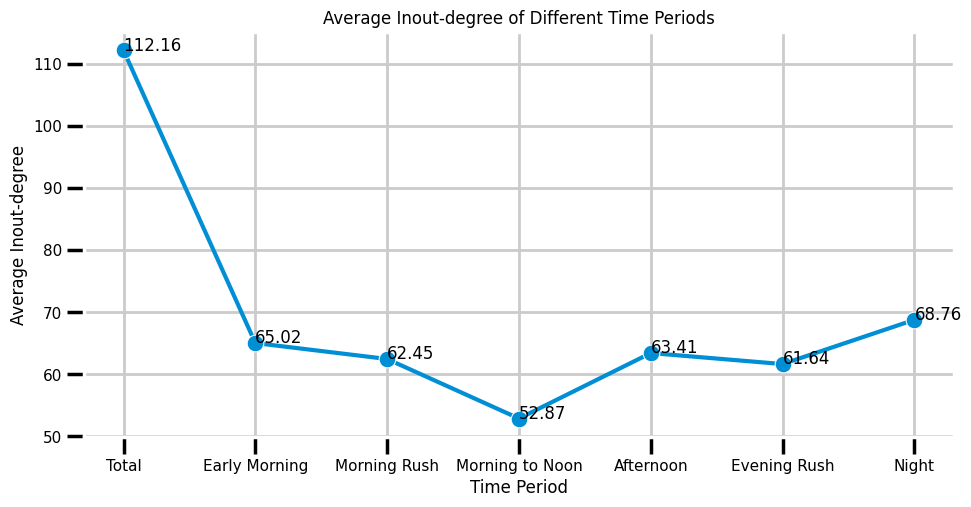

In [13]:
with plt.style.context("fivethirtyeight"), sns.plotting_context(context="poster",font_scale=0.5):
    fig,ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('white')  # 设置整个图的背景颜色为白色
    line = sns.lineplot(x=df_statistics.index, y="Average inout-degree", data=df_statistics,marker = "o")
    
    ax.set_facecolor('white')    # 设置轴的边框颜色为白色
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        
    for x, y in zip(df_statistics.index, df_statistics["Average inout-degree"]):
        ax.text(x, y, f'{y:.2f}', color='black', ha='left')
    plt.xlabel("Time Period")
    plt.ylabel("Average Inout-degree")
    plt.title("Average Inout-degree of Different Time Periods")

# Structure

在有向图中，节点i的聚类系数定义为所有可能的有向三元组（即i -> j, j -> k, k -> i）的比例，其中j和k是i的邻居。一个有向三元组是一个节点对的有序三元组。

nx.average_clustering()函数默认会将有向图视为无向图进行计算。如果你想要计算有向图的聚类系数，需要将count_zeros参数设置为False

In [14]:
# avg_clustering = nx.average_clustering(G, count_zeros=False)
# avg_clustering